<a href="https://colab.research.google.com/github/AUT-Student/SML-HW2/blob/main/SML_HW2_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>In the name of God</b></center>

<b>Course</b>: Statistical Machine Learning
<br>
<b>Description:</b> HomeWork 2 | Question 3
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

In [16]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import bisect

# Dataset

In [2]:
!gdown 1C3-EiTRDvlFGY_IdBNsb_ixlVlyq6mCp
!unzip /content/SML_HW2_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1C3-EiTRDvlFGY_IdBNsb_ixlVlyq6mCp
To: /content/SML_HW2_dataset.zip
100% 14.0k/14.0k [00:00<00:00, 18.7MB/s]
Archive:  /content/SML_HW2_dataset.zip
   creating: Datasets/
   creating: Datasets/earthquake fiji/
  inflating: Datasets/earthquake fiji/details.txt  
  inflating: Datasets/earthquake fiji/quakes.csv  
  inflating: Datasets/old Faithful.zip  
Archive:  /content/Datasets/old Faithful.zip
  inflating: faithful.csv            


In [3]:
!cat /content/Datasets/earthquake\ fiji/details.txt

Locations of Earthquakes off Fiji

Description:

     The data set give the locations of 1000 seismic events of MB >
     4.0. The events occurred in a cube near Fiji since 1964.

Usage:

     quakes

Format:

     A data frame with 1000 observations on 5 variables.

       [,1]  lat       numeric  Latitude of event
       [,2]  long      numeric  Longitude
       [,3]  depth     numeric  Depth (km)
       [,4]  mag       numeric  Richter Magnitude
       [,5]  stations  numeric  Number of stations reporting

Details:
: 

     There are two clear planes of seismic activity.  One is a major
     plate junction; the other is the Tonga trench off New Zealand. 
     These data constitute a subsample from a larger dataset of
     containing 5000 observations.

Source:

     This is one of the Harvard PRIM-H project data sets.  They in turn
     obtained it from Dr. John Woodhouse, Dept. of Geophysics, Harvard
     University.


In [7]:
dataset = pd.read_csv("/content/Datasets/earthquake fiji/quakes.csv", index_col=0)

In [8]:
dataset

,lat,long,depth,mag,stations
1,-20.42,181.62,562,4.8,41
2,-20.62,181.03,650,4.2,15
3,-26.00,184.10,42,5.4,43
4,-17.97,181.66,626,4.1,19
5,-20.42,181.96,649,4.0,11
...,...,...,...,...,...
996,-25.93,179.54,470,4.4,22
997,-12.28,167.06,248,4.7,35
998,-20.13,184.20,244,4.5,34
999,-17.40,187.80,40,4.5,14


In [10]:
mags = dataset["mag"].values

In [14]:
mags.sort()

# Empritical CDF

In [39]:
def estimated_cdf(sorted_samples, x):
  n = len(sorted_samples)
  return bisect.bisect_right(sorted_samples, x) / 1000

In [40]:
mags[0], mags[-1]

(4.0, 6.4)

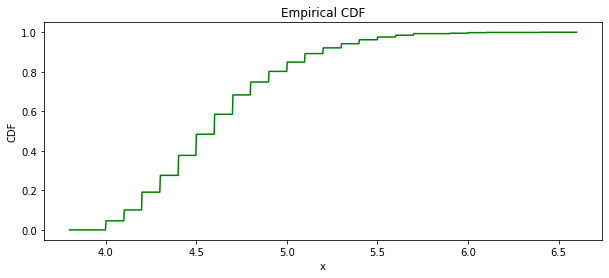

In [41]:
x = np.linspace(3.8, 6.6, 1000)
y = np.array(list(map(lambda x:estimated_cdf(mags, x), x)))
plt.xlabel("x")
plt.ylabel("CDF")
plt.title("Empirical CDF")
plt.plot(x,y,c="green")
plt.gcf().set_size_inches(10,4)
plt.show()

# CDF Band

In [46]:
def estimated_cdf_band(sorted_samples, x, alpha=0.05):
  alpha = 0.05
  n = len(sorted_samples)
  epsilon = (1/(2*n)*np.log(2/alpha))**0.5

  L_x = max(estimated_cdf(sorted_samples, x)-epsilon, 0)
  U_x = min(estimated_cdf(sorted_samples, x)+epsilon, 1) 

  return L_x, U_x

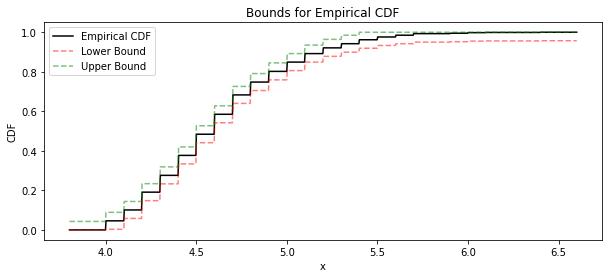

In [57]:
x = np.linspace(3.8, 6.6, 1000)
y = np.array(list(map(lambda x:estimated_cdf(mags, x), x)))
y_l = np.array(list(map(lambda x:estimated_cdf_band(mags, x)[0], x)))
y_u = np.array(list(map(lambda x:estimated_cdf_band(mags, x)[1], x)))

plt.xlabel("x")
plt.ylabel("CDF")
plt.title("Bounds for Empirical CDF")
plt.plot(x, y, c="black", label="Empirical CDF")
plt.plot(x, y_l, "--", c="red", alpha=0.5, label="Lower Bound")
plt.plot(x, y_u, "--", c="green", alpha=0.5, label="Upper Bound")
plt.legend()
plt.gcf().set_size_inches(10,4)
plt.show()

# Confidence Interval

In [59]:
def bootstrap(samples, g, B=100):
  T_stars = []
  n = len(samples)
  for _ in range(B):
    bootstrap_samples = np.array(random.choices(samples, k=n))
    T_star = g(bootstrap_samples)
    T_stars.append(T_star)

  T_stars = np.array(T_stars)
  bootstrap_variance = T_stars.var()

  return bootstrap_variance

In [60]:
g = lambda samples: estimated_cdf(sorted(samples), 4.9) - estimated_cdf(sorted(samples), 4.3)

In [69]:
bootstrap_se = bootstrap(mags, g)**0.5
g_estimation = g(mags)

## Normal

In [70]:
print(f"Estimation = {g_estimation}, se = {bootstrap_se}")

Estimation = 0.526, se = 0.0155683139742234


In [71]:
z = 1.65 # Z_alpha/2 = 0.05  

In [72]:
print(g_estimation - bootstrap_se, g_estimation + bootstrap_se) 

0.5104316860257766 0.5415683139742234


## Percentile Interval

In [76]:
def bootstrap_percentile_interval(samples, g, B=1000, alpha=0.05):
  T_stars = []
  n = len(samples)
  for _ in range(B):
    bootstrap_samples = np.array(random.choices(samples, k=n))
    T_star = g(bootstrap_samples)
    T_stars.append(T_star)

  T_stars = np.array(T_stars)
  T_stars.sort()

  a = T_stars[int(alpha/2*B)]
  b = T_stars[-int(alpha/2*B)]
  return a, b

In [77]:
bootstrap_percentile_interval(mags, g)

(0.494, 0.5569999999999999)

## Pivotal Interval

In [79]:
def bootstrap_pivotal_interval(samples, g, B=1000, alpha=0.05):
  T_stars = []
  n = len(samples)
  for _ in range(B):
    bootstrap_samples = np.array(random.choices(samples, k=n))
    T_star = g(bootstrap_samples)
    T_stars.append(T_star)

  T_stars = np.array(T_stars)
  T_stars.sort()

  a = 2*g(samples) - T_stars[-int(alpha/2*B)]
  b = 2*g(samples) - T_stars[int(alpha/2*B)]
  return a, b

In [80]:
bootstrap_pivotal_interval(mags, g)

(0.4950000000000001, 0.556)